# A more compact, sleeker PSF checker

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io  .dst_io         as     dstio

from IC.invisible_cities.database              import load_db
#from IC.invisible_cities.io      .kdst_io      import psf_writer
# he's dead jim, make psf_writer yourself

import functions as func

%load_ext autoreload
%autoreload 2

In [2]:
class PSFfactors(tb.IsDescription):
    nevt   = tb. UInt32Col(pos=0)
    xr     = tb.Float32Col(pos=1)
    yr     = tb.Float32Col(pos=2)
    zr     = tb.Float32Col(pos=3)
    x      = tb.Float32Col(pos=4)
    y      = tb.Float32Col(pos=5)
    z      = tb.Float32Col(pos=6)
    factor = tb.Float32Col(pos=7)

def psf_writer(hdf5_file, **kwargs):
    psf_table = make_table(hdf5_file,
                           group       = "PSF",
                           name        = "PSFs",
                           fformat     = PSFfactors,
                           description = "XYZ dependent point spread functions",
                           compression = 'ZLIB4')

    def write_psf(xr, yr, zr, xp, yp, zp, fr, nr):
        row = psf_table.row
        for i, x in enumerate(xr):
            for j, y in enumerate(yr):
                for k, z in enumerate(zr):
                    row["xr"    ] = x
                    row["yr"    ] = y
                    row["zr"    ] = z
                    row["x"     ] = xp
                    row["y"     ] = yp
                    row["z"     ] = zp
                    row["factor"] = fr[i,j,k]
                    row["nevt"  ] = nr[i,j,k]
                    row.append()
    return write_psf

# Default config bits

In [3]:
# normalised?
norm = True

## Read PSFs

load your PSFs in here

In [4]:
psf_path  = 'psfs/'
psf_path2 = '../Tl_studies/psf_study/psfs/'

In [5]:
#psf_data_MC = dstio.load_dst(psf_path + 'NEXT100_PSF_kr83m_5bar.h5', 'PSF', 'PSFs')
#psf_data_R14913 = dstio.load_dst(psf_path + 'eutropia_14913_PSF_merged_sectors_1mm.h5', 'PSF', 'PSFs')
psf_data_R14914 = dstio.load_dst(psf_path + 'psf_14914_1mm.psf', 'PSF', 'PSFs')
psf_data_R14913 = dstio.load_dst(psf_path + 'psf_14913_1mm.psf', 'PSF', 'PSFs')
psf_data_R14675 = dstio.load_dst(psf_path + 'eutropia_14675_PSF_merged_sectors_1mm.h5', 'PSF', 'PSFs')
#psf_data_R14915 = dstio.load_dst(psf_path + 'eutropia_14915_PSF_merged_sectors_1mm.h5', 'PSF', 'PSFs')
#psf_data_R14675 = dstio.load_dst(psf_path + 'eutropia_14675_PSF_merged_sectors.h5', 'PSF', 'PSFs')
psf_MC_4bar = dstio.load_dst(psf_path + 'n100_mc_4bar.psf', 'PSF', 'PSFs')


In [6]:
# calculate Delta r
R14914_rr = func.rr_process(psf_data_R14914)
R14913_rr = func.rr_process(psf_data_R14913)
R14675_rr = func.rr_process(psf_data_R14675)
MC4bar_rr = func.rr_process(psf_MC_4bar)

# Plot Z spacing

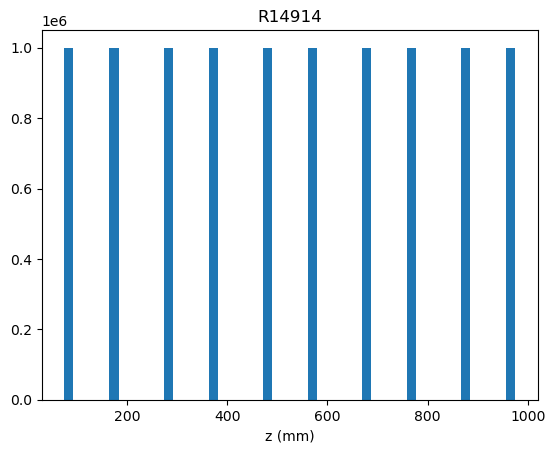

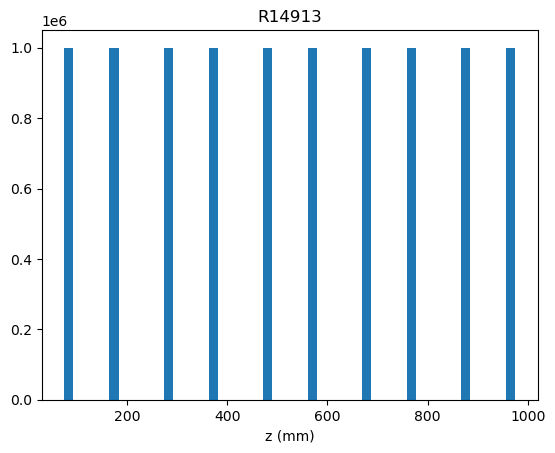

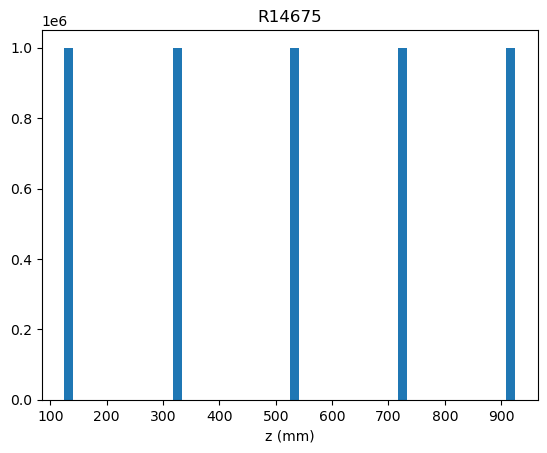

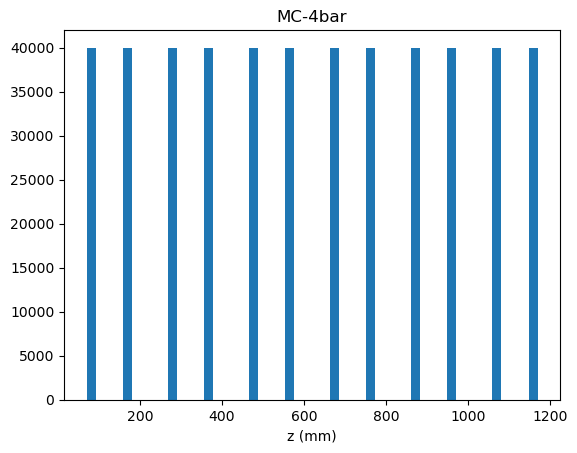

R14914 - Z spacing
[ 75. 175. 275. 375. 475. 575. 675. 775. 875. 975.]

R14675 - Z spacing
[125. 325. 525. 725. 925.]

MC-4bar - Z spacing
[  70.  170.  270.  370.  470.  570.  670.  770.  870.  970. 1070. 1170.]



In [7]:
func.plot_z_bins(psf_data_R14914, 50, 'R14914')
func.plot_z_bins(psf_data_R14913, 50, 'R14913')
func.plot_z_bins(psf_data_R14675, 50, 'R14675')
func.plot_z_bins(psf_MC_4bar, 50, 'MC-4bar')

print('R14914 - Z spacing')
print(psf_data_R14914.z.unique())
print('========================\n')
print('R14675 - Z spacing')
print(psf_data_R14675.z.unique())
print('========================\n')
print('MC-4bar - Z spacing')
print(psf_MC_4bar.z.unique())
print('========================\n')

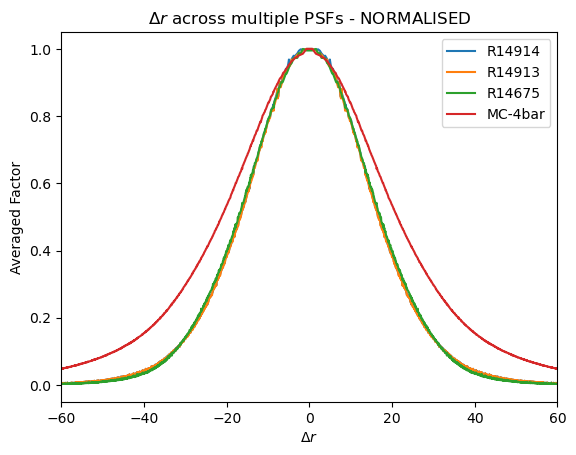

In [8]:
# So lets choose somewhere central in the detector for PSF comparison
func.plot_psf(R14914_rr, 'R14914', norm)
func.plot_psf(R14913_rr, 'R14913', norm)
func.plot_psf(R14675_rr, 'R14675', norm)
func.plot_psf(MC4bar_rr, 'MC-4bar', norm)

plt.xlabel("$\Delta r$")
plt.ylabel("Averaged Factor")


if norm:
    plt.title("$\Delta r$ across multiple PSFs - NORMALISED")
else:
    plt.title("$\Delta r$ across multiple PSFs")

plt.xlim([-60,60])
#plt.yscale('log')
plt.legend()
plt.show()


## lets select some z values

Text(0.5, 1.0, 'PSFs across $\\Delta r$')

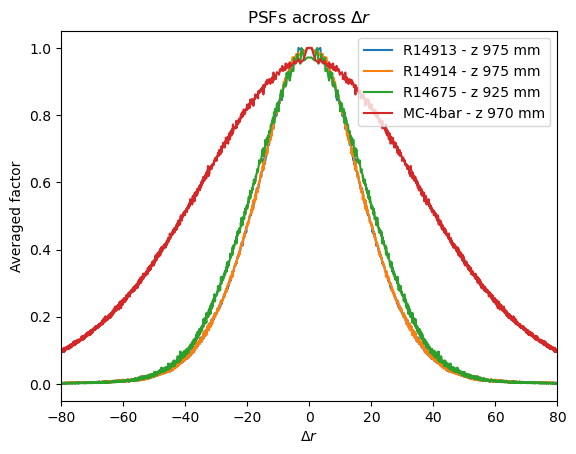

In [36]:
z_R14914 = 975
z_R14913 = 975
z_R14675 = 925
z_MC4bar = 970

func.create_plots_psf(psf_data_R14913, z_R14913, f'R14913 - z {z_R14913} mm', norm)
func.create_plots_psf(psf_data_R14914, z_R14914, f'R14914 - z {z_R14914} mm', norm)
func.create_plots_psf(psf_data_R14675, z_R14675, f'R14675 - z {z_R14675} mm', norm)
func.create_plots_psf(psf_MC_4bar, z_MC4bar, f'MC-4bar - z {z_MC4bar} mm', norm)

## one mm psf
plt.xlabel("$\Delta r$")
plt.ylabel("Averaged factor")
plt.xlim([-80, 80])
#plt.yscale('log')
plt.legend()
plt.title("PSFs across $\Delta r$")

Text(0.5, 1.0, 'PSFs across $\\Delta r$')

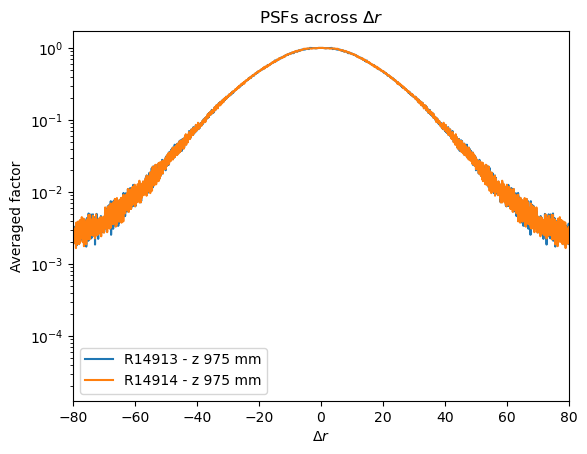

In [37]:
func.create_plots_psf(psf_data_R14913, z_R14913, f'R14913 - z {z_R14913} mm', norm)
func.create_plots_psf(psf_data_R14914, z_R14914, f'R14914 - z {z_R14914} mm', norm)
plt.xlabel("$\Delta r$")
plt.ylabel("Averaged factor")
plt.xlim([-80, 80])
plt.yscale('log')
plt.legend()
plt.title("PSFs across $\Delta r$")

# whats the difference here...

,rr,factor
0,0.707107,0.057297
1,1.581139,0.056674
2,2.121320,0.057036
3,2.549510,0.057027
4,2.915476,0.057096
...,...,...
74723,704.281549,0.000067
74724,704.985461,0.000006
74725,704.986879,0.000023
74726,705.692922,0.000050


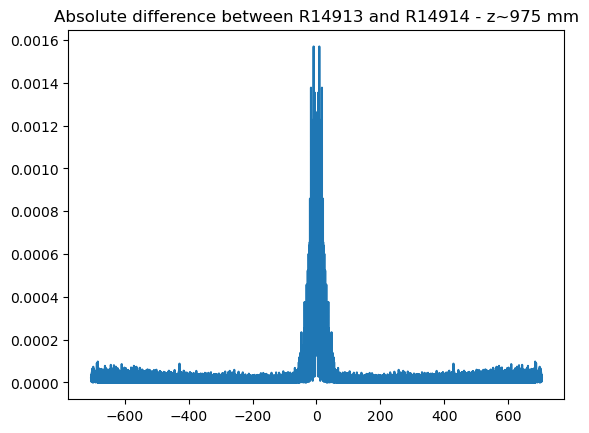

In [38]:
r13 = func.z_specific_rr(psf_data_R14913, z_R14913)
r14 = func.z_specific_rr(psf_data_R14914, z_R14914)

display(r13)
df_13_14_sub = r13.copy(deep=True)
df_13_14_sub['factor'] = abs(r13.factor - r14.factor)

func.plot_psf(df_13_14_sub, 'R14913 - R14914 subtraction')

plt.title(f'Absolute difference between R14913 and R14914 - z~{z_R14913} mm')
plt.show()

Text(0.5, 1.0, 'PSFs across $\\Delta r$')

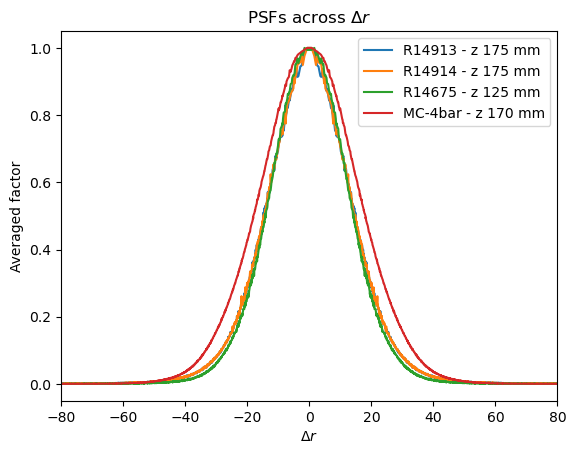

In [39]:
z_R14914 = 175
z_R14913 = 175
z_R14675 = 125
z_MC4bar = 170

func.create_plots_psf(psf_data_R14913, z_R14913, f'R14913 - z {z_R14913} mm', norm)
func.create_plots_psf(psf_data_R14914, z_R14914, f'R14914 - z {z_R14914} mm', norm)
func.create_plots_psf(psf_data_R14675, z_R14675, f'R14675 - z {z_R14675} mm', norm)
func.create_plots_psf(psf_MC_4bar, z_MC4bar, f'MC-4bar - z {z_MC4bar} mm', norm)

## one mm psf
plt.xlabel("$\Delta r$")
plt.ylabel("Averaged factor")
plt.xlim([-80, 80])
#plt.yscale('log')
plt.legend()
plt.title("PSFs across $\Delta r$")

,rr,factor
0,0.707107,0.103679
1,1.581139,0.102265
2,2.121320,0.099611
3,2.549510,0.098185
4,2.915476,0.097995
...,...,...
74723,704.281549,0.000014
74724,704.985461,0.000039
74725,704.986879,0.000029
74726,705.692922,0.000010


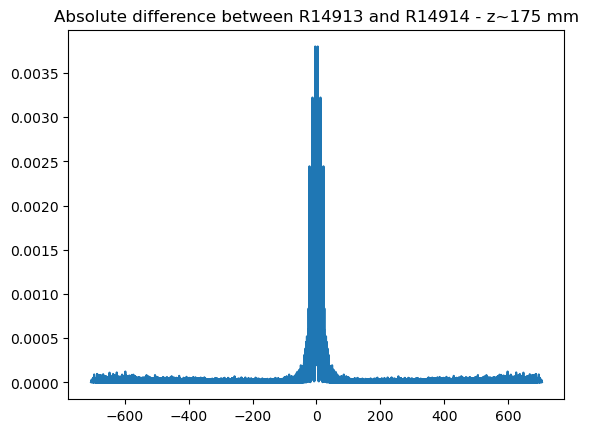

In [40]:
r13 = func.z_specific_rr(psf_data_R14913, z_R14913)
r14 = func.z_specific_rr(psf_data_R14914, z_R14914)

display(r13)
df_13_14_sub = r13.copy(deep=True)
df_13_14_sub['factor'] = abs(r13.factor - r14.factor)

func.plot_psf(df_13_14_sub, 'R14913 - R14914 subtraction')

plt.title(f'Absolute difference between R14913 and R14914 - z~{z_R14913} mm')
plt.show()

Text(0.5, 1.0, 'PSFs across $\\Delta r$')

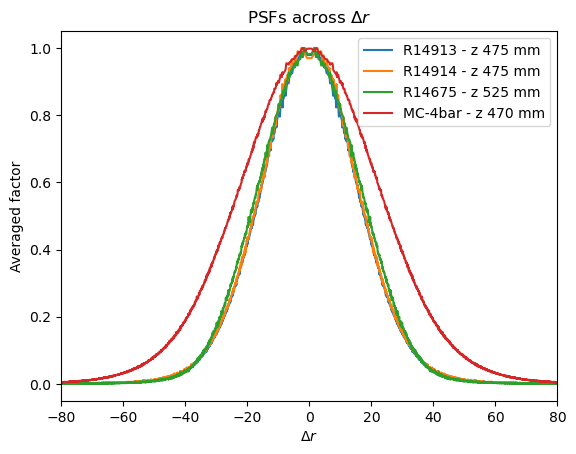

In [41]:
z_R14914 = 475
z_R14913 = 475
z_R14675 = 525
z_MC4bar = 470

func.create_plots_psf(psf_data_R14913, z_R14913, f'R14913 - z {z_R14913} mm', norm)
func.create_plots_psf(psf_data_R14914, z_R14914, f'R14914 - z {z_R14914} mm', norm)
func.create_plots_psf(psf_data_R14675, z_R14675, f'R14675 - z {z_R14675} mm', norm)
func.create_plots_psf(psf_MC_4bar, z_MC4bar, f'MC-4bar - z {z_MC4bar} mm', norm)

## one mm psf
plt.xlabel("$\Delta r$")
plt.ylabel("Averaged factor")
plt.xlim([-80, 80])
#plt.yscale('log')
plt.legend()
plt.title("PSFs across $\Delta r$")

,rr,factor
0,0.707107,0.071435
1,1.581139,0.072990
2,2.121320,0.070991
3,2.549510,0.071067
4,2.915476,0.072090
...,...,...
74723,704.281549,0.000015
74724,704.985461,0.000025
74725,704.986879,0.000023
74726,705.692922,0.000044


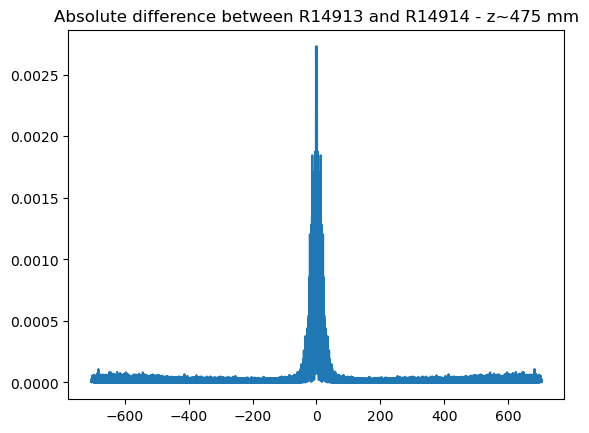

In [42]:
r13 = func.z_specific_rr(psf_data_R14913, z_R14913)
r14 = func.z_specific_rr(psf_data_R14914, z_R14914)

display(r13)
df_13_14_sub = r13.copy(deep=True)
df_13_14_sub['factor'] = abs(r13.factor - r14.factor)

func.plot_psf(df_13_14_sub, 'R14913 - R14914 subtraction')

plt.title(f'Absolute difference between R14913 and R14914 - z~{z_R14913} mm')
plt.show()